In [26]:
#https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/

In [361]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot



In [362]:
ab_path='../data/SPY-Daily-Y09-Now.csv'

start_date='2021-01-01'
end_date='2021-12-31'

prediction_col='MACD'
#my_features=['Price', 'EMA1', 'MACD', 'RSI']

# Load Data

In [363]:
dataset=pd.read_csv(f'{ab_path}',parse_dates=['Date/Time'],dayfirst=True)
dataset.rename(columns={'Date/Time':'Date'},inplace=True)
dataset.set_index('Date',inplace=True)
dataset.sort_index(inplace=True)
dataset=dataset.loc[start_date:end_date,[prediction_col]]
dataset.info()
dataset.head()

# line plot


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2021-01-04 to 2021-12-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MACD    252 non-null    float64
dtypes: float64(1)
memory usage: 3.9 KB


,MACD
Date,
2021-01-04,1.96
2021-01-05,1.87
2021-01-06,1.96
2021-01-07,2.47
2021-01-08,3.00


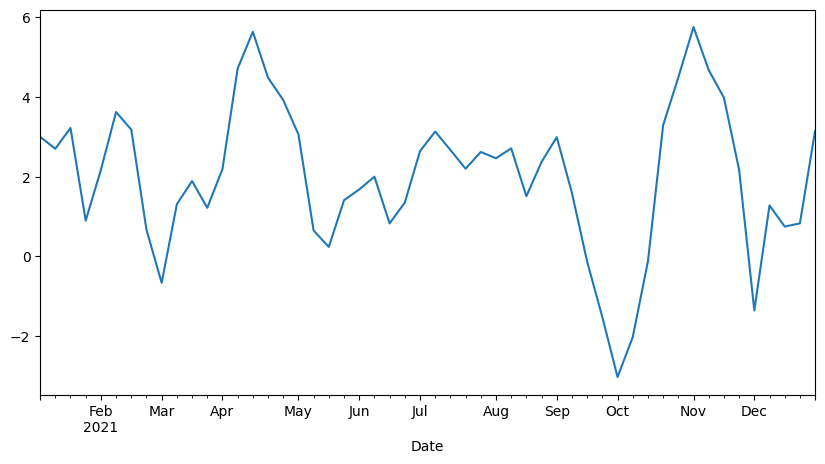

In [364]:
dataset.resample( 'W-FRI').last()[prediction_col].plot(figsize=(10,5))
pyplot.show()

In [365]:
# convert time series into supervised learning and split data
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


# create a differenced series
# feature enginerring
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# Transform Data to LSTM

In [369]:
n_lag = 25
n_seq = 5

print("transform series to array")

data_values = dataset[prediction_col].values
data_values = data_values.reshape(len(data_values), 1)
# data_values = diff_values.reshape(len(diff_values), 1)
print("data values")
print(data_values.shape)
print(data_values[:5])


# print("feature eng by differing value")
# diff_series = difference(raw_values, 1)
# print("diff series")
# print(diff_series[:5])
# print(diff_series.shape)
# data_values = diff_series.values
# data_values = diff_values.reshape(len(diff_values), 1)
# print("diff value")
# print(data_values[:5])
# print(data_values.shape)


transform series to array
data values
(252, 1)
[[1.96]
 [1.87]
 [1.96]
 [2.47]
 [3.  ]]


In [370]:
print("scale data")
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_values = scaler.fit_transform(data_values)
scaled_values = scaled_values.reshape(len(scaled_values), 1)

print(scaled_values.shape)
print(scaled_values[:5])


scale data
(252, 1)
[[0.15811966]
 [0.13888889]
 [0.15811966]
 [0.26709402]
 [0.38034188]]


In [371]:
print("transform into supervised learning problem X, y")
supervised = series_to_supervised(scaled_values, n_lag, n_seq)
supervised_values = supervised.values

print(supervised_values.shape)
print(supervised_values[:3])


transform into supervised learning problem X, y
(223, 30)
[[ 0.15811966  0.13888889  0.15811966  0.26709402  0.38034188  0.40384615
   0.41239316  0.42521368  0.39957265  0.31623932  0.2991453   0.37606838
   0.42735043  0.42735043  0.44444444  0.43162393  0.23931624  0.1474359
  -0.06837607 -0.11752137 -0.05769231 -0.01068376  0.0982906   0.20299145
   0.32264957  0.3974359   0.43803419  0.46581197  0.51282051  0.52564103]
 [ 0.13888889  0.15811966  0.26709402  0.38034188  0.40384615  0.41239316
   0.42521368  0.39957265  0.31623932  0.2991453   0.37606838  0.42735043
   0.42735043  0.44444444  0.43162393  0.23931624  0.1474359  -0.06837607
  -0.11752137 -0.05769231 -0.01068376  0.0982906   0.20299145  0.32264957
   0.3974359   0.43803419  0.46581197  0.51282051  0.52564103  0.52350427]
 [ 0.15811966  0.26709402  0.38034188  0.40384615  0.41239316  0.42521368
   0.39957265  0.31623932  0.2991453   0.37606838  0.42735043  0.42735043
   0.44444444  0.43162393  0.23931624  0.1474359  -0.

In [373]:
print("split into train and test sets")

n_test_ratio = 0.1
n_test=int(len(data_values)*n_test_ratio)
print(n_test)

train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
print(train.shape)
print(test.shape)


split into train and test sets
25
(198, 30)
(25, 30)


In [374]:
print("reshape training into [samples, timesteps, features]")
X, y = train[:, 0:n_lag], train[:, n_lag:]
X = X.reshape(X.shape[0], 1, X.shape[1])
print(X.shape)
print(X[:3])

print(y.shape)
print(y[:3])

reshape training into [samples, timesteps, features]
(198, 1, 25)
[[[ 0.15811966  0.13888889  0.15811966  0.26709402  0.38034188
    0.40384615  0.41239316  0.42521368  0.39957265  0.31623932
    0.2991453   0.37606838  0.42735043  0.42735043  0.44444444
    0.43162393  0.23931624  0.1474359  -0.06837607 -0.11752137
   -0.05769231 -0.01068376  0.0982906   0.20299145  0.32264957]]

 [[ 0.13888889  0.15811966  0.26709402  0.38034188  0.40384615
    0.41239316  0.42521368  0.39957265  0.31623932  0.2991453
    0.37606838  0.42735043  0.42735043  0.44444444  0.43162393
    0.23931624  0.1474359  -0.06837607 -0.11752137 -0.05769231
   -0.01068376  0.0982906   0.20299145  0.32264957  0.3974359 ]]

 [[ 0.15811966  0.26709402  0.38034188  0.40384615  0.41239316
    0.42521368  0.39957265  0.31623932  0.2991453   0.37606838
    0.42735043  0.42735043  0.44444444  0.43162393  0.23931624
    0.1474359  -0.06837607 -0.11752137 -0.05769231 -0.01068376
    0.0982906   0.20299145  0.32264957  0.39743

In [375]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping

n_epochs =  100
n_batch = 1 #1
n_neurons = 1   # NStep from prev prediction consquecialy , need 1 step only
#n_neurons = X.shape[1] * X.shape[2]

print("fit an LSTM network to training data")

print("design network")
model = Sequential()
model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
model.add(Dense(y.shape[1]))
model.compile(loss='mean_squared_error', optimizer='adam')
print("fit network")
for i in range(n_epochs):
    print(i)
    model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
    model.reset_states()
    
print("fit model")


fit an LSTM network to training data
design network
fit network
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
fit model


In [376]:
print("make one forecast with an LSTM")
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

print("evaluate the persistence model")
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts



make one forecast with an LSTM
evaluate the persistence model


In [377]:
# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted
 
# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = np.array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# inverted.append(inv_scale)
        
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)           
		inverted.append(inv_diff)
	return inverted
 

In [378]:
# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))
 


In [383]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
forecasts = inverse_transform(dataset[prediction_col], forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(dataset[prediction_col], actual, scaler, n_test+2)
evaluate_forecasts(actual, forecasts, n_lag, n_seq)

1/1 [==============================] - 0s 42ms/step
t+1 RMSE: 0.700332
t+2 RMSE: 1.443972
t+3 RMSE: 2.415591
t+4 RMSE: 3.655868
t+5 RMSE: 5.066337


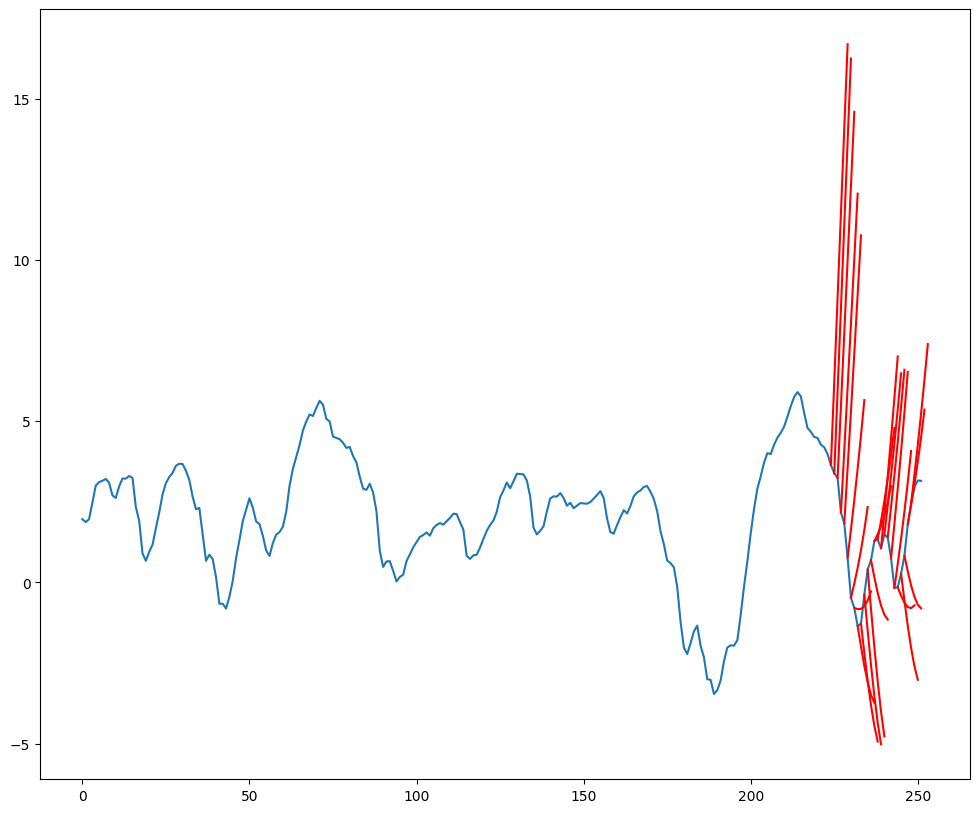

In [380]:
# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
    
	pyplot.figure(figsize=(12,10))
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

plot_forecasts(dataset[prediction_col], forecasts, n_test+2)


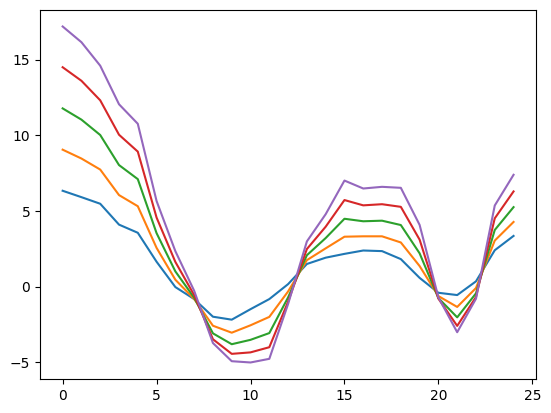

In [391]:
pyplot.plot(forecasts)

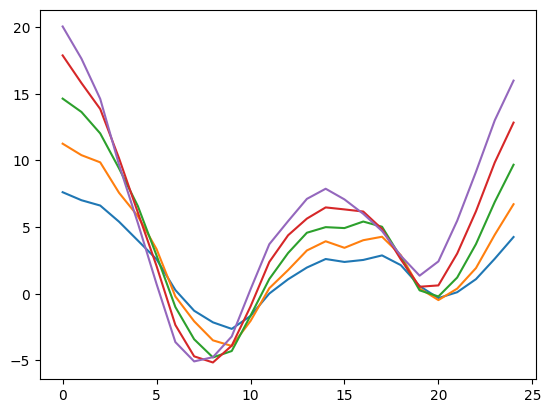

In [393]:
pyplot.plot(actual)